# Purple Box
* Objective: 'RMSE'
* Number of models: 32
* Features: 125
* Add noise to train targets

In [1]:
import pickle
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, CatBoostClassifier

from plot_utils import fast_hist

# Load data

In [2]:
%%time

with open('../data/processed/train.pcl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test.pcl', 'rb') as f:
    test = pickle.load(f)
    
train = train.sort_values(['fact_temperature', 'climate', 'fact_cwsm_class', 
                           'fact_latitude', 'fact_longitude', 'fact_time'])

train.index = [x for x in range(train.shape[0])]
test.index = [x for x in range(test.shape[0])]

print('Train:', train.shape)
print('Test:', test.shape, '\n')

Train: (3129592, 131)
Test: (1137731, 125) 

Wall time: 3.71 s


# Model params

In [3]:
target = 'fact_temperature'
features = list(test.columns) 
print('Features:', len(features))
features

Features: 125


['topography_bathymetry',
 'sun_elevation',
 'climate_temperature',
 'climate_pressure',
 'cmc_0_0_0_1000',
 'cmc_0_0_0_2_grad',
 'cmc_0_0_0_2_interpolated',
 'cmc_0_0_0_2_next',
 'cmc_0_0_0_2',
 'cmc_0_0_0_500',
 'cmc_0_0_0_700',
 'cmc_0_0_0_850',
 'cmc_0_0_0_925',
 'cmc_0_0_6_2',
 'cmc_0_0_7_1000',
 'cmc_0_0_7_2',
 'cmc_0_0_7_500',
 'cmc_0_0_7_700',
 'cmc_0_0_7_850',
 'cmc_0_0_7_925',
 'cmc_0_1_0_0',
 'cmc_0_1_11_0',
 'cmc_0_1_65_0',
 'cmc_0_1_66_0',
 'cmc_0_1_67_0',
 'cmc_0_1_68_0',
 'cmc_0_1_7_0',
 'cmc_0_2_2_10',
 'cmc_0_2_2_1000',
 'cmc_0_2_2_500',
 'cmc_0_2_2_700',
 'cmc_0_2_2_850',
 'cmc_0_2_2_925',
 'cmc_0_2_3_10',
 'cmc_0_2_3_1000',
 'cmc_0_2_3_500',
 'cmc_0_2_3_700',
 'cmc_0_2_3_850',
 'cmc_0_2_3_925',
 'cmc_0_3_0_0',
 'cmc_0_3_0_0_next',
 'cmc_0_3_1_0',
 'cmc_0_3_5_1000',
 'cmc_0_3_5_500',
 'cmc_0_3_5_700',
 'cmc_0_3_5_850',
 'cmc_0_3_5_925',
 'cmc_0_6_1_0',
 'cmc_available',
 'cmc_horizon_h',
 'cmc_precipitations',
 'cmc_timedelta_s',
 'gfs_2m_dewpoint',
 'gfs_a_vorticity'

In [4]:
# Catboost params

model_params = {'eval_metric': 'RMSE',    
                'objective': 'RMSE',
                'iterations':20000,
                'learning_rate':0.45,               
                'depth': 9, 
                'l2_leaf_reg': 20,
                'one_hot_max_size': 120,
                'task_type': 'CPU',
                'thread_count': 22
               }

train_params = {'early_stopping_rounds': 150, 
                'silent': True,
                'plot': True               
               }

features_params = {}

# Adding noise to target variables

In [5]:
train[target].value_counts().sort_index()

-46.0     1
-45.0     3
-44.0     7
-43.0     6
-42.0    20
         ..
 53.0     7
 54.0     5
 60.0     1
 63.0     1
 64.0     1
Name: fact_temperature, Length: 105, dtype: int64

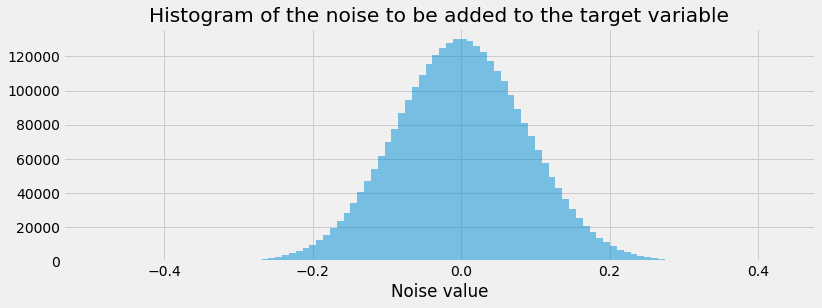

In [6]:
# Since the fact_temperature values have been rounded off, the actual temperature values are shifted within + -0.5 degrees.
# During training, noise in the range from -0.49 to 0.49 degrees will be added to the target variables in train_dataset
# The noise has a normal distribution and is generated by the following code

noise = np.random.randn(train.shape[0])  
noise = noise / np.abs(noise).max() * 0.49

fast_hist(pd.Series(noise), bins=100, title="Histogram of the noise to be added to the target variable", plot_legend=False)
plt.xlabel('Noise value');

# Train models

In [ ]:
%%time

n_models = 50
folds = 25
seed_shift = 0
total_models = 32

for model_number in range(total_models):
    # Fix seed
    seed = model_number + seed_shift
    model_params['random_state'] = seed
    np.random.seed(seed)
    print(f'\nModel: {model_number}, seed: {seed}')
    print(str(datetime.datetime.now())[:19]) 
    
    # Split train val
    train_idx = [x for x in range(train.shape[0]) if x%folds != model_number%folds] 
    val_idx = [x for x in range(train.shape[0]) if x%folds == model_number%folds] 
    print('Train indexes:', train_idx[:folds])
    print('Test indexes:', val_idx[:folds][:5])
    train_subset = train.iloc[train_idx]
    val_subset = train.iloc[val_idx]
    
    # Add noise    
    noise = np.random.randn(train_subset.shape[0])  
    noise = noise / np.abs(noise).max() * 0.49
    
    train_dataset = Pool(data=train_subset[features], label=train_subset[target] + noise, **features_params) 
    eval_dataset = Pool(data=val_subset[features], label=val_subset[target], **features_params)
    
    # Train model
    model = CatBoostRegressor(**model_params) 
    model.fit(train_dataset, eval_set=eval_dataset, **train_params)
    model.save_model(f'models/purple_box_{model_number}_{folds}_{n_models}.cbm')